Training labels after cleanup: ['negative' 'neutral' 'positive']


Loading text data:   7%|▋         | 276/4000 [00:00<00:01, 2755.78it/s]

Loading text data: 100%|██████████| 4000/4000 [00:01<00:00, 2303.03it/s]


Classes found by LabelEncoder: ['negative' 'neutral' 'positive']
Encoded labels range: 0 to 2


Loading image data: 100%|██████████| 4000/4000 [00:43<00:00, 92.54it/s] 


Epoch 1/5


Validating Epoch 1: 100%|██████████| 25/25 [00:38<00:00,  1.56s/it]


New best Val Accuracy: 0.5737. Model saved to C:/Users/cpj/Desktop/ECNU/大三第一学期/当代人工智能/实验5/output6\best_model.pth
Epoch 1: Train Loss = 31.4651, Val Loss = 4.5908, Val Accuracy = 0.5737, Time = 509.34s
Epoch 2/5


Validating Epoch 2: 100%|██████████| 25/25 [00:38<00:00,  1.55s/it]


Validation accuracy did not improve for 1 epoch(s).
Epoch 2: Train Loss = 3.6697, Val Loss = 10.4034, Val Accuracy = 0.5563, Time = 532.83s
Epoch 3/5


Validating Epoch 3: 100%|██████████| 25/25 [00:41<00:00,  1.65s/it]


New best Val Accuracy: 0.6062. Model saved to C:/Users/cpj/Desktop/ECNU/大三第一学期/当代人工智能/实验5/output6\best_model.pth
Epoch 3: Train Loss = 4.3732, Val Loss = 14.8325, Val Accuracy = 0.6062, Time = 531.46s
Epoch 4/5


Validating Epoch 4: 100%|██████████| 25/25 [00:39<00:00,  1.60s/it]


Validation accuracy did not improve for 1 epoch(s).
Epoch 4: Train Loss = 4.5339, Val Loss = 20.0450, Val Accuracy = 0.5687, Time = 539.34s
Epoch 5/5


Validating Epoch 5: 100%|██████████| 25/25 [00:36<00:00,  1.47s/it]


Validation accuracy did not improve for 2 epoch(s).
Epoch 5: Train Loss = 5.5946, Val Loss = 30.4610, Val Accuracy = 0.5925, Time = 504.65s


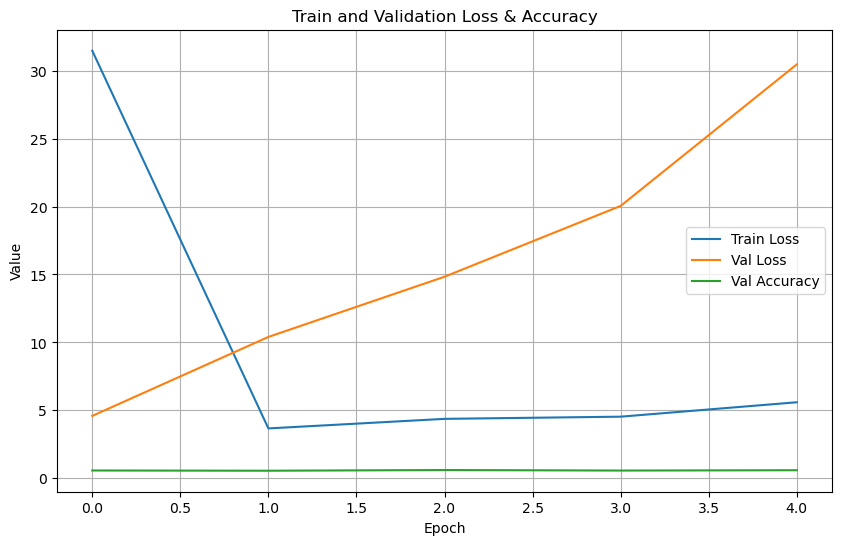

Starting Test Set Prediction...


Loading test data:  16%|█▌        | 83/511 [00:00<00:03, 110.34it/s]

Loading test data:  54%|█████▎    | 274/511 [00:02<00:02, 101.86it/s]

Loading test data: 100%|██████████| 511/511 [00:04<00:00, 108.54it/s]


Predicting sentiment labels for test set...


Testing: 100%|██████████| 16/16 [00:23<00:00,  1.45s/it]

Test predictions saved to C:/Users/cpj/Desktop/ECNU/大三第一学期/当代人工智能/实验5/output/test_predictions_lr0.01.csv
Total Training Time: 2646.65 seconds


In [1]:
#lr0.1
import os
import time
import chardet
import pandas as pd
import numpy as np
from PIL import Image
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import torch
from torch import nn
from torchvision import models, transforms
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam
from tqdm import tqdm
import matplotlib.pyplot as plt

# 设置路径
data_dir = "C:/Users/cpj/Desktop/ECNU/大三第一学期/当代人工智能/实验5/data"
train_file = "C:/Users/cpj/Desktop/ECNU/大三第一学期/当代人工智能/实验5/train.txt"
test_file = "C:/Users/cpj/Desktop/ECNU/大三第一学期/当代人工智能/实验5/test_without_label.txt"
result_file = "C:/Users/cpj/Desktop/ECNU/大三第一学期/当代人工智能/实验5/output/test_predictions_lr0.01.csv"
output_dir = "C:/Users/cpj/Desktop/ECNU/大三第一学期/当代人工智能/实验5/output6"

# 创建输出目录（如果不存在）
os.makedirs(output_dir, exist_ok=True)

# 加载训练集标签
train_df = pd.read_csv(train_file, header=None, names=["guid", "label"])

# 清理数据确保标签合法
valid_labels = ["positive", "neutral", "negative"]  # 只允许这三种标签
train_df = train_df[train_df["label"].isin(valid_labels)]  # 过滤出合法数据

# 验证清理后的标签
print(f"Training labels after cleanup: {train_df['label'].unique()}")

# 文本预处理（使用 TF-IDF）
tfidf_vectorizer = TfidfVectorizer(max_features=5000)  # 限制最大特征数量
train_texts = []

# 读取文本内容
for guid in tqdm(train_df["guid"], desc="Loading text data"):
    text_path = os.path.join(data_dir, f"{guid}.txt")
    try:
        with open(text_path, "r", encoding="utf-8") as file:
            train_texts.append(file.read())
    except UnicodeDecodeError:
        try:
            with open(text_path, "r", encoding="gbk") as file:
                train_texts.append(file.read())
        except Exception as e:
            print(f"Warning: Unable to read text file {text_path} due to error: {e}")
            train_texts.append("[TEXT_ERROR]")  # 占位符
    except FileNotFoundError:
        print(f"Warning: File not found - {text_path}")
        train_texts.append("[TEXT_MISSING]")  # 占位符

# 对文本进行 TF-IDF 转换
X_text = tfidf_vectorizer.fit_transform(train_texts).toarray()

# 图像预处理
image_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# 标签编码
label_encoder = LabelEncoder()
y_labels = label_encoder.fit_transform(train_df["label"])

# 打印编码后的标签及其范围
print(f"Classes found by LabelEncoder: {label_encoder.classes_}")
print(f"Encoded labels range: {y_labels.min()} to {y_labels.max()}")

# 加载图像
image_tensors = []
for guid in tqdm(train_df["guid"], desc="Loading image data"):
    image_path = os.path.join(data_dir, f"{guid}.jpg")
    try:
        image = Image.open(image_path).convert("RGB")
    except FileNotFoundError:
        print(f"Warning: Image file not found - {image_path}")
        image = Image.new("RGB", (224, 224))  # 如果图片不存在，生成空白图片
    image_tensor = image_transform(image)
    image_tensors.append(image_tensor)

# 切分数据集
X_train_text, X_val_text, X_train_images, X_val_images, y_train, y_val = train_test_split(
    X_text, image_tensors, y_labels, test_size=0.2, random_state=42
)

# 创建数据集类
class MultimodalDataset(Dataset):
    def __init__(self, text_features, image_tensors, labels=None):
        self.text_features = text_features
        self.image_tensors = image_tensors
        self.labels = labels

    def __len__(self):
        return len(self.text_features)

    def __getitem__(self, idx):
        if self.labels is not None:
            return torch.tensor(self.text_features[idx], dtype=torch.float32), self.image_tensors[idx], torch.tensor(self.labels[idx], dtype=torch.long)
        else:
            return torch.tensor(self.text_features[idx], dtype=torch.float32), self.image_tensors[idx]

# 创建数据集和 DataLoader
train_dataset = MultimodalDataset(X_train_text, X_train_images, y_train)
val_dataset = MultimodalDataset(X_val_text, X_val_images, y_val)

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# 模型设计
class MultimodalEmotionModel(nn.Module):
    def __init__(self, text_input_dim, num_classes):
        super(MultimodalEmotionModel, self).__init__()

        # 文本特征提取
        self.text_fc = nn.Linear(text_input_dim, 256)

        # 图像特征提取
        # 替换 pretrained=True 为 weights=ResNet18_Weights.DEFAULT
        from torchvision.models import ResNet18_Weights  # 引入新的枚举类
        self.resnet = models.resnet18(weights=ResNet18_Weights.DEFAULT)
        self.resnet.fc = nn.Identity()  # 去掉 ResNet 的最后一层全连接层
        self.image_fc = nn.Linear(512, 256)  # ResNet18 输出维度为 512

        # 融合层
        self.fusion_fc = nn.Linear(512, num_classes)  # 动态设置输出类别数

    def forward(self, text_features, image_tensor):
        # 文本特征
        text_output = self.text_fc(text_features)

        # 图像特征
        image_features = self.resnet(image_tensor)
        image_features = self.image_fc(image_features)

        # 融合特征
        combined_features = torch.cat((text_output, image_features), dim=1)
        output = self.fusion_fc(combined_features)
        return output

# 确定输出类别数
num_classes = len(label_encoder.classes_)

# 实例化模型
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MultimodalEmotionModel(text_input_dim=X_text.shape[1], num_classes=num_classes).to(device)

# 损失函数和优化器
criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=1e-1)

# 定义早停机制相关参数
patience = 5  # 当验证集准确率在连续 5 轮未提升时触发早停
delta = 0.001  # 验证集准确率的最小提升幅度小于该值时视为未提升
best_val_accuracy = 0  # 初始化最佳验证准确率
early_stopping_counter = 0  # 连续未提升的计数器

best_model_path = os.path.join(output_dir, "best_model.pth")  # 保存最佳模型的路径

# 训练和评估
train_losses = []
val_losses = []
val_accuracies = []  # 保存每轮验证集准确率

start_time_total = time.time()  # 记录总时间
for epoch in range(5):  # 设置 epoch=30
    print(f"Epoch {epoch+1}/5")
    epoch_start_time = time.time()  # 每个 Epoch 开始时间

    # 训练
    model.train()
    train_loss = 0
    for text_features, image_tensor, labels in tqdm(train_dataloader, desc=f"Training Epoch {epoch+1}"):
        text_features, image_tensor, labels = text_features.to(device), image_tensor.to(device), labels.to(device)
        optimizer.zero_grad()
        output = model(text_features, image_tensor)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_loss /= len(train_dataloader)
    train_losses.append(train_loss)

    # 验证
    model.eval()
    val_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for text_features, image_tensor, labels in tqdm(val_dataloader, desc=f"Validating Epoch {epoch+1}"):
            text_features, image_tensor, labels = text_features.to(device), image_tensor.to(device), labels.to(device)
            output = model(text_features, image_tensor)
            loss = criterion(output, labels)
            val_loss += loss.item()

            # 计算准确率
            _, predicted = torch.max(output, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
    val_loss /= len(val_dataloader)
    val_losses.append(val_loss)
    val_accuracy = correct / total
    val_accuracies.append(val_accuracy)

    # 检查是否达到新的最佳验证准确率
    if val_accuracy > best_val_accuracy + delta:  # 有显著提升
        best_val_accuracy = val_accuracy
        early_stopping_counter = 0  # 重置早停计数器
        # 保存当前最佳模型
        torch.save(model.state_dict(), best_model_path)
        print(f"New best Val Accuracy: {val_accuracy:.4f}. Model saved to {best_model_path}")
    else:  # 未提升
        early_stopping_counter += 1
        print(f"Validation accuracy did not improve for {early_stopping_counter} epoch(s).")

    # 如果触发早停，终止训练
    if early_stopping_counter >= patience:
        print(f"Early stopping triggered after {epoch+1} epochs. Best Val Accuracy: {best_val_accuracy:.4f}")
        break

    # 当前 Epoch 时间
    epoch_end_time = time.time()
    print(f"Epoch {epoch+1}: Train Loss = {train_loss:.4f}, Val Loss = {val_loss:.4f}, Val Accuracy = {val_accuracy:.4f}, Time = {epoch_end_time - epoch_start_time:.2f}s")

# 绘制 Train Loss 和 Val Loss 折线图
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.plot(val_accuracies, label="Val Accuracy")  # 新增
plt.title("Train and Validation Loss & Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.savefig(os.path.join(output_dir, "loss_accuracy_curve.png"))
plt.show()

# 测试集预测
print("Starting Test Set Prediction...")
test_df = pd.read_csv(test_file)
test_texts = []
test_image_tensors = []

# 检测文件编码并读取文件
def read_file_with_auto_encoding(file_path):
    with open(file_path, "rb") as f:
        raw_data = f.read()
        result = chardet.detect(raw_data)
        encoding = result["encoding"] if result["encoding"] else "utf-8"  # 默认用 utf-8
        try:
            return raw_data.decode(encoding)
        except Exception as e:
            print(f"Warning: Unable to decode file {file_path} with detected encoding {encoding}: {e}")
            return "[TEXT_ERROR]"

# 加载测试集
for guid in tqdm(test_df["guid"], desc="Loading test data"):
    text_path = os.path.join(data_dir, f"{guid}.txt")
    image_path = os.path.join(data_dir, f"{guid}.jpg")

    # 加载文本数据
    if os.path.exists(text_path):
        test_texts.append(read_file_with_auto_encoding(text_path))
    else:
        print(f"Warning: Test text file not found - {text_path}")
        test_texts.append("[TEXT_MISSING]")

    # 加载图像数据
    try:
        image = Image.open(image_path).convert("RGB")
    except FileNotFoundError:
        print(f"Warning: Test image file not found - {image_path}")
        image = Image.new("RGB", (224, 224))  # 生成空白图片
    test_image_tensors.append(image_transform(image))

# 对测试集文本进行 TF-IDF 转换
X_test_text = tfidf_vectorizer.transform(test_texts).toarray()

# 构建测试集 DataLoader
test_dataset = MultimodalDataset(X_test_text, test_image_tensors)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# 模型推断
model.eval()
predictions = []
print("Predicting sentiment labels for test set...")
with torch.no_grad():
    for text_features, image_tensor in tqdm(test_dataloader, desc="Testing"):
        text_features, image_tensor = text_features.to(device), image_tensor.to(device)
        output = model(text_features, image_tensor)
        _, predicted = torch.max(output, 1)
        predictions.extend(predicted.cpu().numpy())

# 将预测结果替换到测试集文件中
test_df["tag"] = label_encoder.inverse_transform(predictions)  # 转换为原始标签名称
test_df.to_csv(result_file, index=False)  # 保存结果
print(f"Test predictions saved to {result_file}")

# 总运行时间
end_time_total = time.time()
print(f"Total Training Time: {end_time_total - start_time_total:.2f} seconds")

Training labels after cleanup: ['negative' 'neutral' 'positive']


Loading text data:   5%|▍         | 196/4000 [00:00<00:01, 1930.03it/s]

Loading text data: 100%|██████████| 4000/4000 [00:01<00:00, 2384.71it/s]


Classes found by LabelEncoder: ['negative' 'neutral' 'positive']
Encoded labels range: 0 to 2


Loading image data: 100%|██████████| 4000/4000 [00:35<00:00, 112.54it/s]


Epoch 1/5


Validating Epoch 1: 100%|██████████| 25/25 [00:42<00:00,  1.69s/it]


New best Val Accuracy: 0.6025. Model saved to C:/Users/cpj/Desktop/ECNU/大三第一学期/当代人工智能/实验5/output7\best_model.pth
Epoch 1: Train Loss = 0.9134, Val Loss = 0.9220, Val Accuracy = 0.6025, Time = 538.04s
Epoch 2/5


Validating Epoch 2: 100%|██████████| 25/25 [00:41<00:00,  1.64s/it]


New best Val Accuracy: 0.6325. Model saved to C:/Users/cpj/Desktop/ECNU/大三第一学期/当代人工智能/实验5/output7\best_model.pth
Epoch 2: Train Loss = 0.5912, Val Loss = 0.8599, Val Accuracy = 0.6325, Time = 546.38s
Epoch 3/5


Validating Epoch 3: 100%|██████████| 25/25 [00:39<00:00,  1.60s/it]


New best Val Accuracy: 0.6412. Model saved to C:/Users/cpj/Desktop/ECNU/大三第一学期/当代人工智能/实验5/output7\best_model.pth
Epoch 3: Train Loss = 0.3226, Val Loss = 0.9402, Val Accuracy = 0.6412, Time = 538.62s
Epoch 4/5


Validating Epoch 4: 100%|██████████| 25/25 [00:39<00:00,  1.59s/it]


Validation accuracy did not improve for 1 epoch(s).
Epoch 4: Train Loss = 0.1987, Val Loss = 1.0587, Val Accuracy = 0.6225, Time = 536.44s
Epoch 5/5


Validating Epoch 5: 100%|██████████| 25/25 [00:39<00:00,  1.56s/it]


Validation accuracy did not improve for 2 epoch(s).
Epoch 5: Train Loss = 0.1312, Val Loss = 1.1965, Val Accuracy = 0.6150, Time = 535.33s


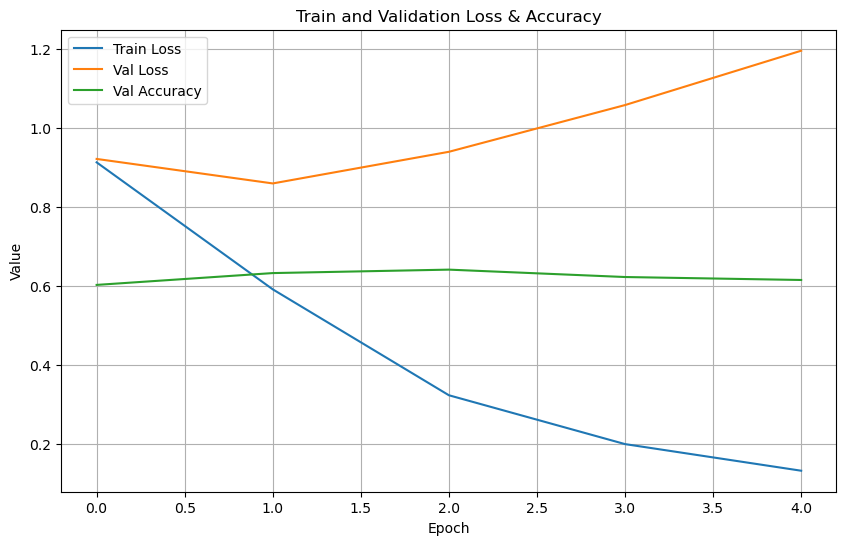

Starting Test Set Prediction...


Loading test data:  15%|█▌        | 79/511 [00:00<00:03, 109.30it/s]

Loading test data:  56%|█████▌    | 284/511 [00:02<00:02, 103.01it/s]

Loading test data: 100%|██████████| 511/511 [00:04<00:00, 106.88it/s]


Predicting sentiment labels for test set...


Testing: 100%|██████████| 16/16 [00:25<00:00,  1.61s/it]

Test predictions saved to C:/Users/cpj/Desktop/ECNU/大三第一学期/当代人工智能/实验5/output/test_predictions_lr0.001.csv
Total Training Time: 2726.45 seconds


In [1]:
#lr0.001
import os
import time
import chardet
import pandas as pd
import numpy as np
from PIL import Image
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import torch
from torch import nn
from torchvision import models, transforms
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam
from tqdm import tqdm
import matplotlib.pyplot as plt

# 设置路径
data_dir = "C:/Users/cpj/Desktop/ECNU/大三第一学期/当代人工智能/实验5/data"
train_file = "C:/Users/cpj/Desktop/ECNU/大三第一学期/当代人工智能/实验5/train.txt"
test_file = "C:/Users/cpj/Desktop/ECNU/大三第一学期/当代人工智能/实验5/test_without_label.txt"
result_file = "C:/Users/cpj/Desktop/ECNU/大三第一学期/当代人工智能/实验5/output/test_predictions_lr0.001.csv"
output_dir = "C:/Users/cpj/Desktop/ECNU/大三第一学期/当代人工智能/实验5/output7"

# 创建输出目录（如果不存在）
os.makedirs(output_dir, exist_ok=True)

# 加载训练集标签
train_df = pd.read_csv(train_file, header=None, names=["guid", "label"])

# 清理数据确保标签合法
valid_labels = ["positive", "neutral", "negative"]  # 只允许这三种标签
train_df = train_df[train_df["label"].isin(valid_labels)]  # 过滤出合法数据

# 验证清理后的标签
print(f"Training labels after cleanup: {train_df['label'].unique()}")

# 文本预处理（使用 TF-IDF）
tfidf_vectorizer = TfidfVectorizer(max_features=5000)  # 限制最大特征数量
train_texts = []

# 读取文本内容
for guid in tqdm(train_df["guid"], desc="Loading text data"):
    text_path = os.path.join(data_dir, f"{guid}.txt")
    try:
        with open(text_path, "r", encoding="utf-8") as file:
            train_texts.append(file.read())
    except UnicodeDecodeError:
        try:
            with open(text_path, "r", encoding="gbk") as file:
                train_texts.append(file.read())
        except Exception as e:
            print(f"Warning: Unable to read text file {text_path} due to error: {e}")
            train_texts.append("[TEXT_ERROR]")  # 占位符
    except FileNotFoundError:
        print(f"Warning: File not found - {text_path}")
        train_texts.append("[TEXT_MISSING]")  # 占位符

# 对文本进行 TF-IDF 转换
X_text = tfidf_vectorizer.fit_transform(train_texts).toarray()

# 图像预处理
image_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# 标签编码
label_encoder = LabelEncoder()
y_labels = label_encoder.fit_transform(train_df["label"])

# 打印编码后的标签及其范围
print(f"Classes found by LabelEncoder: {label_encoder.classes_}")
print(f"Encoded labels range: {y_labels.min()} to {y_labels.max()}")

# 加载图像
image_tensors = []
for guid in tqdm(train_df["guid"], desc="Loading image data"):
    image_path = os.path.join(data_dir, f"{guid}.jpg")
    try:
        image = Image.open(image_path).convert("RGB")
    except FileNotFoundError:
        print(f"Warning: Image file not found - {image_path}")
        image = Image.new("RGB", (224, 224))  # 如果图片不存在，生成空白图片
    image_tensor = image_transform(image)
    image_tensors.append(image_tensor)

# 切分数据集
X_train_text, X_val_text, X_train_images, X_val_images, y_train, y_val = train_test_split(
    X_text, image_tensors, y_labels, test_size=0.2, random_state=42
)

# 创建数据集类
class MultimodalDataset(Dataset):
    def __init__(self, text_features, image_tensors, labels=None):
        self.text_features = text_features
        self.image_tensors = image_tensors
        self.labels = labels

    def __len__(self):
        return len(self.text_features)

    def __getitem__(self, idx):
        if self.labels is not None:
            return torch.tensor(self.text_features[idx], dtype=torch.float32), self.image_tensors[idx], torch.tensor(self.labels[idx], dtype=torch.long)
        else:
            return torch.tensor(self.text_features[idx], dtype=torch.float32), self.image_tensors[idx]

# 创建数据集和 DataLoader
train_dataset = MultimodalDataset(X_train_text, X_train_images, y_train)
val_dataset = MultimodalDataset(X_val_text, X_val_images, y_val)

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# 模型设计
class MultimodalEmotionModel(nn.Module):
    def __init__(self, text_input_dim, num_classes):
        super(MultimodalEmotionModel, self).__init__()

        # 文本特征提取
        self.text_fc = nn.Linear(text_input_dim, 256)

        # 图像特征提取
        # 替换 pretrained=True 为 weights=ResNet18_Weights.DEFAULT
        from torchvision.models import ResNet18_Weights  # 引入新的枚举类
        self.resnet = models.resnet18(weights=ResNet18_Weights.DEFAULT)
        self.resnet.fc = nn.Identity()  # 去掉 ResNet 的最后一层全连接层
        self.image_fc = nn.Linear(512, 256)  # ResNet18 输出维度为 512

        # 融合层
        self.fusion_fc = nn.Linear(512, num_classes)  # 动态设置输出类别数

    def forward(self, text_features, image_tensor):
        # 文本特征
        text_output = self.text_fc(text_features)

        # 图像特征
        image_features = self.resnet(image_tensor)
        image_features = self.image_fc(image_features)

        # 融合特征
        combined_features = torch.cat((text_output, image_features), dim=1)
        output = self.fusion_fc(combined_features)
        return output

# 确定输出类别数
num_classes = len(label_encoder.classes_)

# 实例化模型
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MultimodalEmotionModel(text_input_dim=X_text.shape[1], num_classes=num_classes).to(device)

# 损失函数和优化器
criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=1e-3)

# 定义早停机制相关参数
patience = 5  # 当验证集准确率在连续 5 轮未提升时触发早停
delta = 0.001  # 验证集准确率的最小提升幅度小于该值时视为未提升
best_val_accuracy = 0  # 初始化最佳验证准确率
early_stopping_counter = 0  # 连续未提升的计数器

best_model_path = os.path.join(output_dir, "best_model.pth")  # 保存最佳模型的路径

# 训练和评估
train_losses = []
val_losses = []
val_accuracies = []  # 保存每轮验证集准确率

start_time_total = time.time()  # 记录总时间
for epoch in range(5):  # 设置 epoch=30
    print(f"Epoch {epoch+1}/5")
    epoch_start_time = time.time()  # 每个 Epoch 开始时间

    # 训练
    model.train()
    train_loss = 0
    for text_features, image_tensor, labels in tqdm(train_dataloader, desc=f"Training Epoch {epoch+1}"):
        text_features, image_tensor, labels = text_features.to(device), image_tensor.to(device), labels.to(device)
        optimizer.zero_grad()
        output = model(text_features, image_tensor)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_loss /= len(train_dataloader)
    train_losses.append(train_loss)

    # 验证
    model.eval()
    val_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for text_features, image_tensor, labels in tqdm(val_dataloader, desc=f"Validating Epoch {epoch+1}"):
            text_features, image_tensor, labels = text_features.to(device), image_tensor.to(device), labels.to(device)
            output = model(text_features, image_tensor)
            loss = criterion(output, labels)
            val_loss += loss.item()

            # 计算准确率
            _, predicted = torch.max(output, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
    val_loss /= len(val_dataloader)
    val_losses.append(val_loss)
    val_accuracy = correct / total
    val_accuracies.append(val_accuracy)

    # 检查是否达到新的最佳验证准确率
    if val_accuracy > best_val_accuracy + delta:  # 有显著提升
        best_val_accuracy = val_accuracy
        early_stopping_counter = 0  # 重置早停计数器
        # 保存当前最佳模型
        torch.save(model.state_dict(), best_model_path)
        print(f"New best Val Accuracy: {val_accuracy:.4f}. Model saved to {best_model_path}")
    else:  # 未提升
        early_stopping_counter += 1
        print(f"Validation accuracy did not improve for {early_stopping_counter} epoch(s).")

    # 如果触发早停，终止训练
    if early_stopping_counter >= patience:
        print(f"Early stopping triggered after {epoch+1} epochs. Best Val Accuracy: {best_val_accuracy:.4f}")
        break

    # 当前 Epoch 时间
    epoch_end_time = time.time()
    print(f"Epoch {epoch+1}: Train Loss = {train_loss:.4f}, Val Loss = {val_loss:.4f}, Val Accuracy = {val_accuracy:.4f}, Time = {epoch_end_time - epoch_start_time:.2f}s")

# 绘制 Train Loss 和 Val Loss 折线图
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.plot(val_accuracies, label="Val Accuracy")  # 新增
plt.title("Train and Validation Loss & Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.savefig(os.path.join(output_dir, "loss_accuracy_curve.png"))
plt.show()

# 测试集预测
print("Starting Test Set Prediction...")
test_df = pd.read_csv(test_file)
test_texts = []
test_image_tensors = []

# 检测文件编码并读取文件
def read_file_with_auto_encoding(file_path):
    with open(file_path, "rb") as f:
        raw_data = f.read()
        result = chardet.detect(raw_data)
        encoding = result["encoding"] if result["encoding"] else "utf-8"  # 默认用 utf-8
        try:
            return raw_data.decode(encoding)
        except Exception as e:
            print(f"Warning: Unable to decode file {file_path} with detected encoding {encoding}: {e}")
            return "[TEXT_ERROR]"

# 加载测试集
for guid in tqdm(test_df["guid"], desc="Loading test data"):
    text_path = os.path.join(data_dir, f"{guid}.txt")
    image_path = os.path.join(data_dir, f"{guid}.jpg")

    # 加载文本数据
    if os.path.exists(text_path):
        test_texts.append(read_file_with_auto_encoding(text_path))
    else:
        print(f"Warning: Test text file not found - {text_path}")
        test_texts.append("[TEXT_MISSING]")

    # 加载图像数据
    try:
        image = Image.open(image_path).convert("RGB")
    except FileNotFoundError:
        print(f"Warning: Test image file not found - {image_path}")
        image = Image.new("RGB", (224, 224))  # 生成空白图片
    test_image_tensors.append(image_transform(image))

# 对测试集文本进行 TF-IDF 转换
X_test_text = tfidf_vectorizer.transform(test_texts).toarray()

# 构建测试集 DataLoader
test_dataset = MultimodalDataset(X_test_text, test_image_tensors)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# 模型推断
model.eval()
predictions = []
print("Predicting sentiment labels for test set...")
with torch.no_grad():
    for text_features, image_tensor in tqdm(test_dataloader, desc="Testing"):
        text_features, image_tensor = text_features.to(device), image_tensor.to(device)
        output = model(text_features, image_tensor)
        _, predicted = torch.max(output, 1)
        predictions.extend(predicted.cpu().numpy())

# 将预测结果替换到测试集文件中
test_df["tag"] = label_encoder.inverse_transform(predictions)  # 转换为原始标签名称
test_df.to_csv(result_file, index=False)  # 保存结果
print(f"Test predictions saved to {result_file}")

# 总运行时间
end_time_total = time.time()
print(f"Total Training Time: {end_time_total - start_time_total:.2f} seconds")